In [1]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
import math
import numpy as np
sys.path.append('../../pytools')
import d2l

d2l.gpu_mem_init()

2025-11-16 05:22:14.241388: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-16 05:22:14.303234: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-16 05:22:15.754267: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): True


In [2]:
export_saved_model = True
export_h5_model = True
def nin_block(num_channels, kernel_size, strides, padding):
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(num_channels, kernel_size, strides=strides, padding=padding, activation='relu', name='zjtest_conv2d_L1'),
        tf.keras.layers.Conv2D(num_channels, kernel_size=1, activation='relu',name='zjtest_conv2d_L2'),
        tf.keras.layers.Conv2D(num_channels, kernel_size=1, activation='relu',name='zjtest_conv2d_L3')
    ])

In [3]:

input_shape=(224,224,1)
input_layer = tf.keras.layers.Input(name='nin_model_input_zj',shape=input_shape)

def net():
    return tf.keras.models.Sequential([
        input_layer,
        nin_block(96, kernel_size=11, strides=4, padding='valid'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        nin_block(256, kernel_size=5, strides=1, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        nin_block(384, kernel_size=3, strides=1, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.Dropout(0.5),
        nin_block(10, kernel_size=3, strides=1, padding='same'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Reshape((1,1,10)),
        tf.keras.layers.Flatten(name="nin_net_output_zj")
    ])

In [4]:
X = tf.random.uniform((1, 224, 224, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

I0000 00:00:1763241736.739306   31134 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21343 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:00:08.0, compute capability: 7.0
2025-11-16 05:22:17.004346: W external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:237] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 7.0
2025-11-16 05:22:17.004378: W external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:240] Used ptxas at /usr/local/cuda/bin/ptxas
2025-11-16 05:22:17.004445: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-11-16 05:22:17.006497: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-11-16 05:22:17.008643: W tensorfl

Sequential output shape:	 (1, 54, 54, 96)
MaxPooling2D output shape:	 (1, 26, 26, 96)
Sequential output shape:	 (1, 26, 26, 256)
MaxPooling2D output shape:	 (1, 12, 12, 256)
Sequential output shape:	 (1, 12, 12, 384)
MaxPooling2D output shape:	 (1, 5, 5, 384)
Dropout output shape:	 (1, 5, 5, 384)
Sequential output shape:	 (1, 5, 5, 10)
GlobalAveragePooling2D output shape:	 (1, 10)
Reshape output shape:	 (1, 1, 1, 10)
Flatten output shape:	 (1, 10)


loss 2.206, train acc 0.185, test acc 0.330
2802.0 examples/sec on /GPU:0


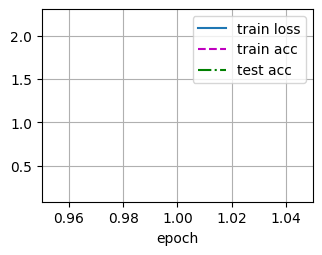

In [5]:
lr, num_epochs, batch_size = 0.1, 1, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
nin_net = d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [6]:
print(nin_net.summary())

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 54, 54, 96)     │        30,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 26, 26, 256)    │       746,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 12, 12, 384)    │     1,180,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 5, 5, 10)       │        34,790 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 10)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 1, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ nin_net_output_zj (Flatten)     │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,992,168 (7.60 MB)

 Trainable params: 1,992,166 (7.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


In [8]:
if export_h5_model:
    nin_net.save_weights(filepath='/home/ubuntu/work/data/nin-net/h5/nin_net.weights.h5')

In [9]:
clone = net()
clone_test = net()
print(clone_test.summary())

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_15 (Sequential)      │ (None, 54, 54, 96)     │        30,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_16 (Sequential)      │ (None, 26, 26, 256)    │       746,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_17 (Sequential)      │ (None, 12, 12, 384)    │     1,180,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 5, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_18 (Sequential)      │ (None, 5, 5, 10)       │        34,790 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 10)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 1, 1, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ nin_net_output_zj (Flatten)     │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,992,166 (7.60 MB)

 Trainable params: 1,992,166 (7.60 MB)

 Non-trainable params: 0 (0.00 B)

None


In [10]:
for x,y in train_iter:
    clone(x)
    break
print(clone.summary())

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_10 (Sequential)      │ (None, 54, 54, 96)     │        30,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_11 (Sequential)      │ (None, 26, 26, 256)    │       746,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_12 (Sequential)      │ (None, 12, 12, 384)    │     1,180,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 5, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_13 (Sequential)      │ (None, 5, 5, 10)       │        34,790 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 10)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 1, 1, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ nin_net_output_zj (Flatten)     │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,992,166 (7.60 MB)

 Trainable params: 1,992,166 (7.60 MB)

 Non-trainable params: 0 (0.00 B)

None


In [11]:
if export_h5_model:
    clone.load_weights(filepath='/home/ubuntu/work/data/nin-net/h5/nin_net.weights.h5')

In [12]:
#保存、加载模型，网络模式
nin_net.save("nin_model.keras")

In [13]:
infer = tf.keras.models.load_model("nin_model.keras")
for x,y in train_iter:
    infer(x)
    break
print(len(infer.layers))

11


In [14]:
if export_saved_model:
    nin_net.export("/home/ubuntu/work/data/nin-net/saved_model")

INFO:tensorflow:Assets written to: /home/ubuntu/work/data/nin-net/saved_model/assets


INFO:tensorflow:Assets written to: /home/ubuntu/work/data/nin-net/saved_model/assets


Saved artifact at '/home/ubuntu/work/data/nin-net/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name='nin_model_input_zj')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140114239092720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140114239704048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140114239708800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140114239709328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140114239715136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140114239712320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140114239713024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140114239738224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140114239738576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140114239735408: TensorSpec(shape=(), dtype=tf.reso

In [15]:
if export_saved_model:
    info_sv = tf.keras.layers.TFSMLayer('/home/ubuntu/work/data/nin-net/saved_model', call_endpoint='serving_default')
    for x,y in train_iter:
        output = info_sv(x)
        print(output)
        break
    print(info_sv)

{'output_0': <tf.Tensor: shape=(128, 10), dtype=float32, numpy=
array([[1.84677052e+00, 1.10269533e-02, 1.80114365e+00, ...,
        4.54275322e+00, 4.31003904e+00, 1.22398591e+00],
       [1.04624319e+00, 0.00000000e+00, 9.04295802e-01, ...,
        1.23490171e+01, 9.18450165e+00, 7.65327024e+00],
       [1.85637450e+00, 3.30508836e-02, 1.47289944e+00, ...,
        6.57931757e+00, 6.10039234e+00, 2.18829441e+00],
       ...,
       [1.50224972e+00, 2.39829440e-02, 1.18826270e+00, ...,
        1.00718203e+01, 7.15581799e+00, 7.87469721e+00],
       [1.03633547e+00, 0.00000000e+00, 1.02445638e+00, ...,
        1.16380301e+01, 8.87525654e+00, 6.45913410e+00],
       [1.01161122e+00, 4.40325588e-02, 8.77494216e-01, ...,
        1.15657425e+01, 8.89897537e+00, 6.42692327e+00]], dtype=float32)>}
<TFSMLayer name=tfsm_layer, built=True>
